### Imports

In [7]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Model.DataLoader import DataLoaderManager
from Model.Train import Trainer
from Model.Loss import Loss
from Model.Test import Tester

## Constants

In [ ]:
epochs = 100
image_size = 224
num_classes = 1
learning_rate = 1e-4
train_size = 0.7
test_size = 0.15
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loading

In [ ]:
dataset = DataLoaderManager(root_dir="patches",kidney_dir=False, data_augmentation=True, shape=(image_size,image_size))

train_size = int(train_size * len(dataset))
test_size =  int(test_size * len(dataset))
val_size = len(dataset) - train_size - test_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataset.show_data(train_loader)
dataset.show_data(val_loader)
dataset.show_data(test_loader) 

print(f"Train size : {len(train_loader)}")
print(f"Validation size : {len(val_loader)}")
print(f"Test size : {len(test_loader)}")

## Model Training
- Encoder can be one of : 
    - 'vgg16', 'vgg19', 
    - 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
    - 'efficientnet-b3'


In [ ]:
encoder_name = 'efficientnet-b3'
model = smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet', classes=num_classes, in_channels=3)
model = model.to(device)
optimizer = torch.optim.AdamW
loss = Loss.combined_loss
trainer = Trainer()
pos_weight = trainer.calculate_weights(train_loader)
print(f"Positive weights : {pos_weight}")
train_loss, val_loss, precision, recall, val_p, val_r = trainer.set_model(model)\
    .set_loader(train_loader, val_loader, test_loader)\
    .set_loss_fn(loss)\
    .set_optimizer(optimizer)\
    .fit(learning_rate, epochs, 1/pos_weight)

## Model saving 
- Path explanation : 
    - [MODEL NAME]\_[MODEL VERSION]\_[LOSS]\_[OPTIMIZER]\_[WEIGHTED CLASS]\_[AUGMENTED DATA]\_[IMAGE_CHANNELS]\_[NUMBER CLUSTERS]\_[NUMBER EPOCHS]

In [ ]:
path_prefix = "EN_b3_BD_adamW_weight_augmented_3D_3C_100epochs"
torch.save(model.state_dict(), f"params/model_params/local_model_{path_prefix}")

## Plotting results

In [ ]:
np.save("params/model_metrics/local_train_loss_{path_prefix}", train_loss)
np.save("params/model_metrics/local_val_loss_{path_prefix}", val_loss)
np.save("params/model_metrics/local_precision_{path_prefix}", precision)
np.save("params/model_metrics/local_recall_{path_prefix}", recall)
np.save("params/model_metrics/local_val_precision_{path_prefix}", val_p)
np.save("params/model_metrics/local_val_recall_{path_prefix}", val_r)

In [ ]:
trainer.plot_loss(train_loss, val_loss)
trainer.plot_precision_recall(precision, recall, val_p, val_r)
trainer.evaluate()

## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


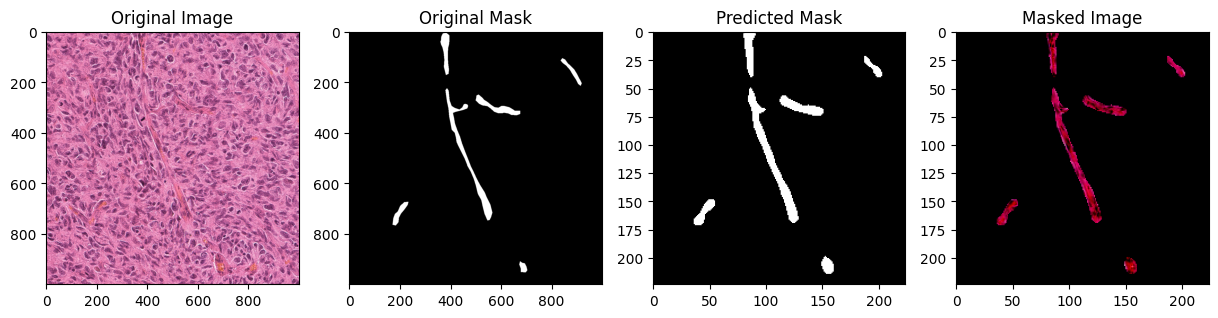

In [6]:
tester = Tester(state="../params/model_params/local_model_EN_b3_BD_adamW_weight_augmented_3D_3C_100epochs")

patch = "2_1265_001B._patches_26_46.png"
cluster = "001B_clustd"

image = Image.open(f"../patches/patches_bvd_clustd/{cluster}/{patch}")
mask = Image.open(f"../patches/patches_bvd_clustd_mask/{cluster}/{patch}").convert('L')

mask_pred, mask_image = tester.predict(image.copy())
 
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1,4,2)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.subplot(1,4,3)
plt.imshow(mask_pred[0], cmap='gray')
plt.title("Predicted Mask")
plt.subplot(1,4,4)
plt.imshow(mask_image)
plt.title("Masked Image")
plt.show()